In [1]:
import os
import io
import csv
import json
import time
import pickle
import gc 
from tqdm import tqdm
from multiprocessing import Manager, Process, Pool
from functools import partial
from itertools import compress, chain, repeat
from operator import itemgetter
import operator as op
from sklearn.preprocessing import normalize

import numpy as np
import pandas as pd
from PIL import Image
import cv2
from skimage.draw import polygon_perimeter
import matplotlib as mpl
# matplotlib.use('TkAgg')
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.stats import entropy, norm, uniform
from torchvision import datasets, transforms

import faiss
from cleanlab.classification import CleanLearning
from cleanlab.filter import find_label_issues, find_predicted_neq_given, find_label_issues_using_argmax_confusion_matrix
from cleanlab.dataset import health_summary
from cleanlab.count import get_confident_thresholds
from cleanlab.rank import get_label_quality_scores, get_normalized_margin_for_each_label, get_self_confidence_for_each_label, get_confidence_weighted_entropy_for_each_label
from cleanlab.internal.label_quality_utils import (
    _subtract_confident_thresholds,
    get_normalized_entropy,
)

from model import Net, GtsrbFolderWithPaths, SwedishFolderWithPaths

from id_to_class import bdd100k_det as id2class
from id_to_class import bdd100k_det_name2RGB as name2RGB

import torch
# not able to choose gpu
device = torch.device("cuda:1") if torch.cuda.is_available() else torch.device("cpu")
#from dataset_config import gtsrb as config
# from id_to_class import gtsrb_classes as classes_name
# from dataset_config import swedish as config
# from id_to_class import swedish_classes as classes_name

In [90]:
def plot_issues(figpath, main_title, data_imgs, labels_gt, id_iter, nrows, ncols, labels_pred, losses, imgnames, labels_gt_des, labels_pred_des, probs, show_img=True):
#     print(f'id_iter={id_iter}')
#     plt.figure()
    dpi = 400
    fig = plt.figure(dpi=dpi, figsize=(20,18))
    
    for count, id in enumerate(id_iter):
        # print(f'id={id}, count={count}')
        # print(f'imgnames={imgnames[id]}')
        # # print(f'data_imgs={data_imgs[id]}')
        # print(f'labels_gt={labels_gt[id]}')
        # print(f'labels_gt_des={labels_gt_des[id]}')
        # # print(f'probs={probs[id]}')
        # print('----')
        
        title = f"{imgnames[id]}\ngt({labels_gt[id]}): {labels_gt_des[id]}\nprob: {probs[id]:.3f}"
        ax = fig.add_subplot(nrows, ncols, count + 1)
        ax.set_title(title, fontdict={'fontsize': 8, 'fontweight': 4})
        plt.imshow(data_imgs[id], cmap="gray")
        #         plt.title(title, fontdict={'fontsize': 4, 'fontweight': 4})
        plt.axis("off")
        # plt.subplots_adjust(wspace=0.4, hspace=0.4, left=0.1, bottom=1, right=0.95, top=3.5)
        
    plt.tight_layout()
    # print(f'# of pyplot figure stack: {plt.get_fignums()}')
    # plt.suptitle(main_title)
    plt.savefig(figpath, dpi=dpi, bbox_inches='tight')

    print(f'show_img={show_img} {type(show_img)}')
    if show_img:
        plt.show()
    # print(f'# of pyplot figure stack: {plt.get_fignums()}')
    
    
# https://github.com/pytorch/pytorch/issues/16797#issuecomment-633423219
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

In [3]:

nsplit = 0
inject_dir = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/Swin-Transformer-Object-Detection/injects'

# Official model and validate on certain split
pkl_path = f'{inject_dir}/faster_rcnn_official_val_split{nsplit}.pkl'
model_name = os.path.basename(pkl_path.replace('.pkl', ''))

# SAM
sam_path1 = '/home/belay/Documents/github_others/segment-anything/notebooks/output/OfficialVal_ShuffleSplit10_Split-0_Sparse_0-399.pkl'
sam_path2 = '/home/belay/Documents/github_others/segment-anything/notebooks/output/OfficialVal_ShuffleSplit10_Split-0_Sparse_400-799.pkl'
sam_path3 = '/home/belay/Documents/github_others/segment-anything/notebooks/output/OfficialVal_ShuffleSplit10_Split-0_Sparse_800-999.pkl'

def read_pkl(pkl_path):
    print(f'Read pkl: {pkl_path}')
    with open(pkl_path, "rb") as f:
        # saved_objs = pickle.load(f)
        pkl = CPU_Unpickler(f).load()
    return pkl

# saved_objs = read_pkl(pkl_path)
sam_objs1 = read_pkl(sam_path1)
sam_objs2 = read_pkl(sam_path2)
sam_objs3 = read_pkl(sam_path3)
print(f'key of a single saved_obj = {list(sam_objs1[0].keys())}')




sam_objs = {
    'img_name': [i['img_name'] for i in sam_objs1] + [i['img_name'] for i in sam_objs2] + [i['img_name'] for i in sam_objs3],
    'img_path': [i['img_path'] for i in sam_objs1] + [i['img_path'] for i in sam_objs2] + [i['img_path'] for i in sam_objs3],
    'img_hw': [i['img_hw'] for i in sam_objs1] + [i['img_hw'] for i in sam_objs2] + [i['img_hw'] for i in sam_objs3],
    'img_id': [i['img_id'] for i in sam_objs1] + [i['img_id'] for i in sam_objs2] + [i['img_id'] for i in sam_objs3],
    'bboxes': [i['bboxes'] for i in sam_objs1] + [i['bboxes'] for i in sam_objs2] + [i['bboxes'] for i in sam_objs3],
    'labels': [i['labels'] for i in sam_objs1] + [i['labels'] for i in sam_objs2] + [i['labels'] for i in sam_objs3],
    'labels_des': [i['labels_des'] for i in sam_objs1] + [i['labels_des'] for i in sam_objs2] + [i['labels_des'] for i in sam_objs3],
    'iou_predictions': [i['iou_predictions'] for i in sam_objs1] + [i['iou_predictions'] for i in sam_objs2] + [i['iou_predictions'] for i in sam_objs3],
    'low_res_logits': [i['low_res_logits'] for i in sam_objs1] + [i['low_res_logits'] for i in sam_objs2] + [i['low_res_logits'] for i in sam_objs3],
    'sparse_embeddings': [i['sparse_embeddings'] for i in sam_objs1] + [i['sparse_embeddings'] for i in sam_objs2] + [i['sparse_embeddings'] for i in sam_objs3],
    # 'dense_embeddings': [i['dense_embeddings'] for i in sam_objs1] + [i['dense_embeddings'] for i in sam_objs2] + [i['dense_embeddings'] for i in sam_objs3]
}

Read pkl: /home/belay/Documents/github_others/segment-anything/notebooks/output/OfficialVal_ShuffleSplit10_Split-0_Sparse_0-399.pkl
Read pkl: /home/belay/Documents/github_others/segment-anything/notebooks/output/OfficialVal_ShuffleSplit10_Split-0_Sparse_400-799.pkl
Read pkl: /home/belay/Documents/github_others/segment-anything/notebooks/output/OfficialVal_ShuffleSplit10_Split-0_Sparse_800-999.pkl
key of a single saved_obj = ['img_name', 'img_path', 'img_hw', 'img_id', 'bboxes', 'labels', 'labels_des', 'iou_predictions', 'low_res_logits', 'sparse_embeddings']


In [4]:
del sam_objs1
del sam_objs2
del sam_objs3

In [5]:
# print(sam_objs[0].keys())
# print(sam_objs[0]['img_name'])
# print(sam_objs[0]['img_path'])
# print(sam_objs[0]['img_hw'])
# print(sam_objs[0]['bboxes'])
# print(sam_objs[0]['labels'])

# filenames = [i["img_name"] for i in sam_objs]
# file_hws = [i["img_hw"] for i in sam_objs]
# filepaths = [i["img_path"] for i in sam_objs]
# img_ids = [i["img_id"] for i in sam_objs]
# bboxes = [i["bboxes"] for i in sam_objs]
# labels = [i["labels"] for i in sam_objs]
# labels_des = [i["labels_des"] for i in sam_objs]
# iou_predictions = [i["iou_predictions"] for i in sam_objs]
# low_res_logits = [i["low_res_logits"] for i in sam_objs]
# sparse_embeddings = [i["sparse_embeddings"] for i in sam_objs]
# dense_embeddings = [i["dense_embeddings"] for i in sam_objs]
# filenames, file_hws, filepaths, bboxes, labels, labels_des, iou_predictions, low_res_logits, sparse_embeddings, dense_embeddings

filenames = sam_objs['img_name']
file_hws = sam_objs['img_hw']
filepaths = sam_objs['img_path']
img_ids = sam_objs['img_id']
bboxes = sam_objs['bboxes']
labels = sam_objs['labels']
labels_des = sam_objs['labels_des']
iou_predictions = sam_objs['iou_predictions']
low_res_logits = sam_objs['low_res_logits']
sparse_embeddings = sam_objs['sparse_embeddings']
# dense_embeddings = sam_objs['dense_embeddings']
print(f'len of filenames={len(filenames)}')
print(f'len of file_hws={len(file_hws)}')
print(f'len of img_ids={len(img_ids)}')
print(f'len of bboxes={len(bboxes)}')
print(f'len of labels={len(labels)}')
print(f'len of labels_des={len(labels_des)}')
print(f'len of iou_predictions={len(iou_predictions)}')
print(f'len of low_res_logits={len(low_res_logits)}')
print(f'len of sparse_embeddings={len(sparse_embeddings)}')
# print(f'len of dense_embeddings={len(dense_embeddings)}')

print(f'len of iou_predictions={iou_predictions[0].shape}')
print(f'len of low_res_logits={low_res_logits[0].shape}')
print(f'len of sparse_embeddings={sparse_embeddings[0].shape}')
# print(f'len of dense_embeddings={dense_embeddings[0].shape}')

len of filenames=1000
len of file_hws=1000
len of img_ids=1000
len of bboxes=1000
len of labels=1000
len of labels_des=1000
len of iou_predictions=1000
len of low_res_logits=1000
len of sparse_embeddings=1000
len of iou_predictions=torch.Size([34, 1])
len of low_res_logits=torch.Size([34, 1, 256, 256])
len of sparse_embeddings=torch.Size([34, 2, 256])


In [6]:
# img_dir = f'{data_dirpath}/bdd100k/bdd100k_images_100k/images/100k/val'
# coco_json_path = f'{data_dirpath}/bdd100k/bdd100k_images_100k/OfficialVal_ShuffleSplit10/Split-0.json'

# with open(coco_json_path, 'r') as f:
#     data = json.loads(f.read())

# anno = data['annotations']
# print(f'images={len(data["images"])}')
# print(f'annotations={len(data["annotations"])}')

# filenames = [i["file_name"] for i in data["images"]]
# file_hws = [(i["height"], i["width"]) for i in data["images"]]
# filepaths = [os.path.join(img_dir, i) for i in filenames]
# img_ids = [i["id"] for i in data["images"]]

# assert len(filenames) == len(img_ids)
# assert len(filepaths) == len(img_ids)

In [7]:
def draw_bboxes(img, bboxes, labels, labels_des, name2RGB):

    for idx, (bbox, label, label_des) in enumerate(zip(bboxes, labels, labels_des)):
        # ymin, xmin, w, h  = [int(i) for i in bbox]
        ymin, xmin, ymax, xmax = bbox
        
        # ymax = (ymin + w)
        # xmax = (xmin + h)

        # xmin, ymin, xmax, ymax = bbox

        # print
        
        r = [xmin, xmax, xmax, xmin, xmin]
        c = [ymax, ymax, ymin, ymin, ymax]
        rr, cc = polygon_perimeter(r, c, img.shape)
        rgb = name2RGB[label_des]
        img[rr, cc ,0] = rgb[0]
        img[rr, cc ,1] = rgb[1]
        img[rr, cc ,2] = rgb[2]

        font = cv2.FONT_HERSHEY_PLAIN
        text_org = (ymin, xmin-2)

        if label_des == 'traffic sign':
            label_des = 'sign'
        elif label_des == 'traffic light':
            label_des = 'light'
            
        cv2.putText(img, label_des, text_org, font, 1, rgb, 1, cv2.LINE_AA)

    return img


def crop_bbox(xmin, ymin, xmax, ymax, img, img_shape, pad=0):
    img_xmax = img_shape[0]
    img_ymax = img_shape[1]
    xmin = int(xmin) - pad if int(xmin) - pad > 0 else 0
    ymin = int(ymin) - pad if int(ymin) - pad > 0 else 0
    xmax = int(xmax) + pad if int(xmin) + pad > 0 else img_xmax
    ymax = int(ymax) + pad if int(ymax) + pad > 0 else img_ymax

    # print(f'img.shape={img.shape}')
    cropped = img[xmin:xmax, ymin:ymax, :]
    # print(f'cropped.shape={cropped.shape}')
    return cropped


def crop_bboxes(img, img_shape, gt_bboxes, gt_labels, pad):
    bbox_imgs = []

    for idx, (bbox, labels) in enumerate(zip(gt_bboxes, gt_labels)):
        ymin, xmin, ymax, xmax = bbox
        # xmin, ymin, xmax, ymax = bbox
        
        bbox_img = crop_bbox(xmin, ymin, xmax, ymax, img, img_shape, pad)
        bbox_imgs.append(bbox_img)

    return bbox_imgs


# def process_coco_bbox(bboxes):
#     new_bboxes = []

#     for bbox in bboxes:
#         ymin, xmin, w, h  = [int(i) for i in bbox]
#         ymax = (ymin + w)
#         xmax = (xmin + h)
#         new_bboxes.append([xmin, ymin, xmax, ymax])
        
#     return new_bboxes

# def process_coco2sam(bboxes):
#     new_bboxes = []

#     for bbox in bboxes:
#         ymin, xmin, w, h  = [int(i) for i in bbox]
#         ymax = (ymin + w)
#         xmax = (xmin + h)
#         new_bboxes.append([ymin, xmin, ymax, xmax])
        
#     return new_bboxes

In [8]:
# bbox_imgs = []
bbox_imgnames = []
bbox_imgpaths = []
bbox_gt_labels = []
bbox_gt_labels_des = []

# len of iou_predictions=torch.Size([34, 1])
# len of low_res_logits=torch.Size([34, 1, 256, 256])
# len of sparse_embeddings=torch.Size([34, 2, 256])
# len of dense_embeddings=torch.Size([34, 256, 64, 64])
bbox_iou_predictions = None
bbox_low_res_logits = None
bbox_sparse_embs = None
bbox_dense_embs = None


# for idx, (img_name, img_hw, img_path, gt_bboxes, gt_labels, gt_labels_des, iou_prediction, low_res_logit, dense_embedding) in enumerate(zip(filenames, file_hws, filepaths, bboxes, labels, labels_des, iou_predictions, low_res_logits, dense_embeddings)):
for idx, (img_name, img_hw, img_path, gt_bboxes, gt_labels, gt_labels_des, iou_prediction, low_res_logit, sparse_embedding) in enumerate(zip(filenames, file_hws, filepaths, bboxes, labels, labels_des, iou_predictions, low_res_logits, sparse_embeddings)):


    if ((idx+1) % 300) == 0:
        print(f'Process # {idx+1} - {img_name}')

    # if idx+1 > 400:
    #     break

    # print(f'Process {img_name}')

    # img = np.array(Image.open(img_path))
    
    # filtered_anno = [i for i in anno if i['image_id'] == img_id]
    # gt_bboxes = [i['bbox'] for i in filtered_anno]
    # gt_bboxes = process_coco_bbox(gt_bboxes)

    # gt_labels = [i['category_id'] for i in filtered_anno]
    # gt_labels_des = [id2class[i-1] for i in gt_labels]

    # print(f'len of gt_bboxes={len(gt_bboxes)}')
    # print(f'len of gt_labels={len(gt_labels)}')
    # print(gt_bboxes)
    assert len(gt_bboxes) == len(gt_labels)

    # img_with_bboxes = draw_bboxes(img, gt_bboxes, gt_labels, gt_labels_des, name2RGB)
    # bbox_per_imgs = crop_bboxes(img_with_bboxes, img_name, gt_bboxes, gt_labels, pad=20)

    # dpi = 150
    # fig = plt.figure(dpi=dpi, figsize=(12,14))
    # plt.imshow(img_with_bboxes)
    # plt.axis('off')
    # plt.show()
    # break

    # print(len(bbox_per_imgs))
    # bbox_imgs.extend(bbox_per_imgs)
    bbox_imgnames.extend([img_name]*len(gt_bboxes))
    bbox_imgpaths.extend([img_path]*len(gt_bboxes))
    bbox_gt_labels.extend(gt_labels)
    bbox_gt_labels_des.extend(gt_labels_des)

    if bbox_iou_predictions is None:
        bbox_iou_predictions = iou_prediction.detach().cpu().numpy()
    else: 
        bbox_iou_predictions = np.concatenate((bbox_iou_predictions, iou_prediction.detach().cpu().numpy()), axis=0)

    if bbox_low_res_logits is None:
        bbox_low_res_logits = low_res_logit.detach().cpu().numpy()
    else: 
        bbox_low_res_logits = np.concatenate((bbox_low_res_logits, low_res_logit.detach().cpu().numpy()), axis=0)

    if bbox_sparse_embs is None:
        bbox_sparse_embs = sparse_embedding.detach().cpu().numpy()
    else: 
        bbox_sparse_embs = np.concatenate((bbox_sparse_embs, sparse_embedding.detach().cpu().numpy()), axis=0)
    
    # if bbox_dense_embs is None:
    #     bbox_dense_embs = dense_embedding.detach().cpu().numpy()
    # else: 
    #     bbox_dense_embs = np.concatenate((bbox_dense_embs, dense_embedding.detach().cpu().numpy()), axis=0)


    # bbox_iou_predictions.extend(iou_prediction.detach().cpu().numpy())
    # bbox_low_res_logits.extend(low_res_logit.detach().cpu().numpy())
    # bbox_sparse_embs.extend(sparse_embedding.detach().cpu().numpy())
    # bbox_dense_embs.extend(dense_embedding.detach().cpu().numpy())
    gc.collect()
    
bbox_iou_predictions = [i[0] for i in bbox_iou_predictions]
bbox_iou_predictions = np.array(bbox_iou_predictions)
bbox_low_res_logits = np.array(bbox_low_res_logits)
bbox_sparse_embs = np.array(bbox_sparse_embs)
bbox_dense_embs = np.array(bbox_dense_embs)

Process # 300 - b26f8762-61cfb033.jpg
Process # 600 - b3422c91-f0c36ed7.jpg
Process # 900 - b409ed8a-da6926db.jpg


In [10]:
# print(f'len bbox_imgs={len(bbox_imgs)}')
# print(f'bbox_imgs[0].shape={bbox_imgs[0].shape}')
# print(f'bbox_imgs[1].shape={bbox_imgs[1].shape}')
# print(f'bbox_imgs[2].shape={bbox_imgs[2].shape}')
# print(f'bbox_imgs[3].shape={bbox_imgs[3].shape}')
print(f'bbox_imgnames.shape={len(bbox_imgnames)}')
print(f'bbox_gt_labels.shape={len(bbox_gt_labels)}')

print(f'bbox_iou_predictions.shape={bbox_iou_predictions.shape}')
# print(f'bbox_iou_predictions={bbox_iou_predictions}')
print(f'bbox_low_res_logits.shape={bbox_low_res_logits.shape}')
print(f'bbox_sparse_embs.shape={bbox_sparse_embs.shape}')
# print(f'bbox_dense_embs.shape={bbox_dense_embs.shape}')

bbox_imgnames.shape=18393
bbox_gt_labels.shape=18393
bbox_iou_predictions.shape=(18393,)
bbox_low_res_logits.shape=(18393, 1, 256, 256)
bbox_sparse_embs.shape=(18393, 2, 256)


In [55]:
# replace bbox_max_probs with bbox_iou_predictions
# set bbox_pred_labels, bbox_pred_labels_des to empty list
bbox_pred_labels = [''] * len(bbox_gt_labels)
bbox_pred_labels_des = [''] * len(bbox_gt_labels)
is_issue = [''] * len(bbox_gt_labels)

df = pd.DataFrame(list(zip(bbox_iou_predictions, bbox_gt_labels, bbox_gt_labels_des, bbox_pred_labels, bbox_pred_labels_des, bbox_imgpaths, bbox_imgnames, is_issue)), columns=['probs', 'labels_gt', 'labels_gt_des', 'labels_pred', 'labels_pred_des', 'paths', 'imgnames', 'is_issue'])

print(len(df['imgnames'].tolist()))
print(len(df['labels_gt'].tolist()))
df.head(5)

18393
18393


probs  labels_gt  labels_gt_des labels_pred labels_pred_des  \
0  0.954696          9   traffic sign                               
1  0.951096          9   traffic sign                               
2  0.943820          9   traffic sign                               
3  0.783505          9   traffic sign                               
4  0.880917          8  traffic light                               

                                               paths               imgnames  \
0  /media/18T/data_thesis/bdd100k/bdd100k_images_...  b1c66a42-6f7d68ca.jpg   
1  /media/18T/data_thesis/bdd100k/bdd100k_images_...  b1c66a42-6f7d68ca.jpg   
2  /media/18T/data_thesis/bdd100k/bdd100k_images_...  b1c66a42-6f7d68ca.jpg   
3  /media/18T/data_thesis/bdd100k/bdd100k_images_...  b1c66a42-6f7d68ca.jpg   
4  /media/18T/data_thesis/bdd100k/bdd100k_images_...  b1c66a42-6f7d68ca.jpg   

  is_issue  
0           
1           
2           
3           
4

In [13]:
# https://github.com/rom1504/image_embeddings/blob/e6233e78b857285c32755587f585fa251cabae17/image_embeddings/knn/knn.py
def build_index(emb_flatten, dist):
    #print(f'emb.shape={emb_flatten.shape}')
    d = emb_flatten.shape[1]
    xb = emb_flatten

    if dist == 'inner product':
        # cosine similarity
        index = faiss.IndexFlatIP(d)
    elif dist == 'euclidean':
        index = faiss.IndexFlatL2(d)

    index.add(xb)
    return index


def search(index, id_to_name, emb, k):
    D, I = index.search(np.expand_dims(emb, 0), k)  # actual search
    return list(zip(D[0], [id_to_name[x] for x in I[0]]))


# Use sparse embedding
embs = bbox_sparse_embs

embs_flatten = np.reshape(embs, (embs.shape[0], embs.shape[1]*embs.shape[2]))
# embs_256 = bbox_feats_all[:,:, 0, 0]
# embs_7x7 = bbox_feats_all[:,0, :, :]
# embs_7x7 = np.reshape(embs_7x7, (embs_7x7.shape[0], embs_7x7.shape[1]*embs_7x7.shape[2]))
embs = embs_flatten

# before normalization
index_ip = build_index(embs, dist='inner product')

embs = normalize(embs, norm="l2", axis=1)
print(f'embs.shape={embs.shape}')
print(f'embs should be unit vector = {np.sum(embs**2, axis=1)}')

# index_l2 = build_index(embs, dist='euclidean')
index_cos = build_index(embs, dist='inner product')



embs.shape=(18393, 512)
embs should be unit vector = [1.0000002  1.0000001  1.         ... 1.         1.         0.99999994]


Try to print 10 items...
------ Creating 10 rows of data ------


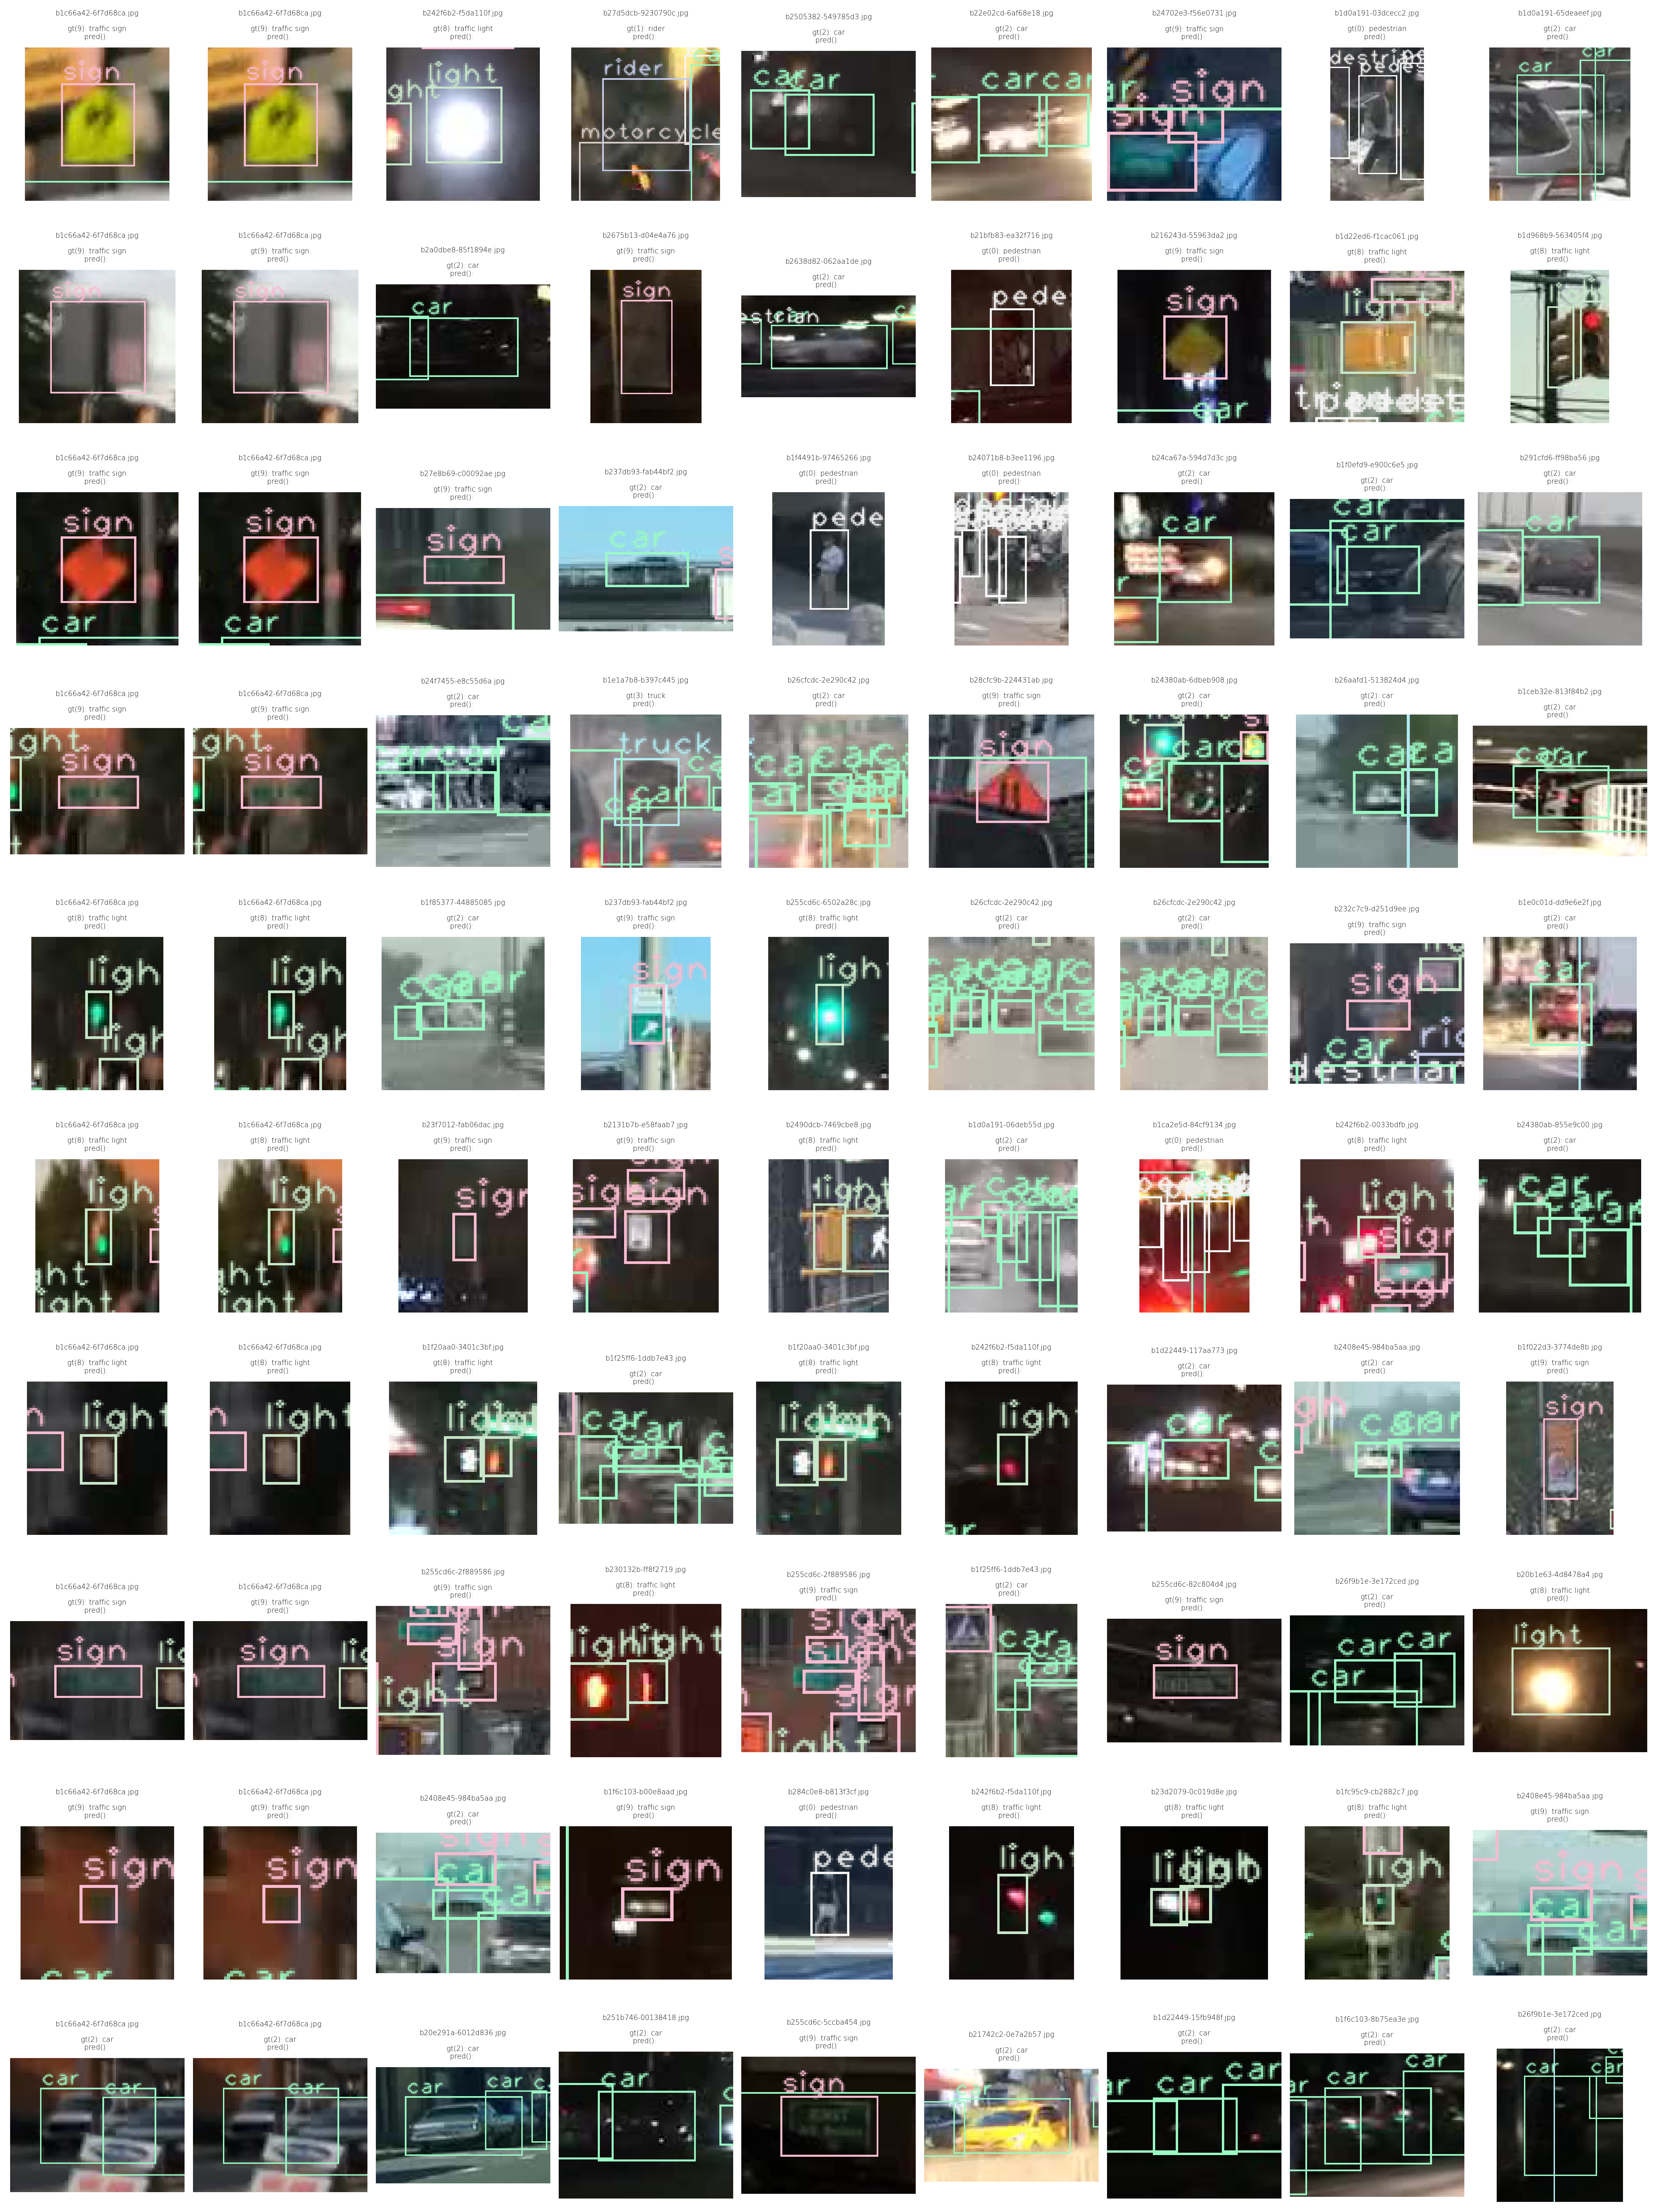

In [12]:

# faiss Document https://github.com/facebookresearch/faiss/wiki/Getting-started
############## Find the neighbors of Incorrect Label ##############
def show_knn_neighbors(figpath, index, id_iter, imgs, is_issues_des, imgnames, imgpaths, labels_gt, labels_gt_des, labels_pred, labels_pred_des, probs, embs, k):

    #print(embs_flatten.shape)
    #print(np.expand_dims(embs[7], 0).shape)
    #return
    #, constrained_layout=True
    knn_list = []
    params = {
        "figure.subplot.left": 0.05,
        "figure.subplot.right": 0.95,
        "figure.subplot.bottom": 0.3,
        "figure.subplot.top": 0.99,
        "figure.subplot.wspace": 0.05,
        "figure.subplot.hspace": 0.99,
    }
    mpl.rcParams.update(params)
    print(f'Try to print {len(id_iter)} items...')
    dpi = 300
    if len(id_iter) <= 5:
        fig = plt.figure(dpi=dpi, figsize=(18,16))
    elif len(id_iter) > 5 and len(id_iter) <= 10:
        fig = plt.figure(dpi=dpi, figsize=(18,22))
    elif len(id_iter) > 10 and len(id_iter) <= 20:
        fig = plt.figure(dpi=dpi, figsize=(18,30))
    elif len(id_iter) > 20:
        fig = plt.figure(dpi=dpi, figsize=(18,60))
        
    # fig.suptitle('Figure title')

    # create 3x1 subfigs
    print(f'------ Creating {len(id_iter)} rows of data ------')
    subfigs = fig.subfigures(nrows=len(id_iter), ncols=1)
    #fig.subplots_adjust(hspace=0.9)
    for row, subfig in enumerate(subfigs):
        # subfig.suptitle(f'Find similar of {imgnames[row]}')
        
        bbox_idx = id_iter[row]
        # print(f'row={row}')
        # print(f'bbox_idx={bbox_idx}, imgnames={imgnames[bbox_idx]}')

        D, I = index.search(np.expand_dims(embs[bbox_idx], axis=0), k=k)
        neighbors = I[:k][0]
        knn_list.append((bbox_idx, neighbors))
        
        # print(f'neighbors={neighbors}')
        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=k+1)
        
        for col, ax in enumerate(axs):
            fontdict={'fontsize': 5, 'fontweight': 4}
            ax.axis('off')
            if col == 0:
                ax.set_title(f'{imgnames[bbox_idx]}\n{is_issues_des[bbox_idx]}\ngt({labels_gt[bbox_idx]}): {labels_gt_des[bbox_idx]}\npred({labels_pred[bbox_idx]}): {labels_pred_des[bbox_idx]}', fontdict=fontdict)
                ax.imshow(imgs[bbox_idx])
                
            else:
                neighbor_idx = neighbors[col-1]

                # title = f'{imgnames[neighbor_idx]}\n{is_issues_des[neighbor_idx]}\ngt({labels_gt[neighbor_idx]}): {labels_gt_des[neighbor_idx]}\npred({labels_pred[neighbor_idx]}): {labels_pred_des[neighbor_idx]}'

                # print(f'imgnames[neighbor_idx]={imgnames[neighbor_idx]}')
                # print(f'is_issues_des[neighbor_idx]={is_issues_des[neighbor_idx]}')
                # print(f'labels_gt[neighbor_idx]={labels_gt[neighbor_idx]}')
                # print(f'labels_gt_des[neighbor_idx]={labels_gt_des[neighbor_idx]}')
                # print(f'labels_pred[neighbor_idx]={labels_pred[neighbor_idx]}')
                # print(f'labels_pred_des[neighbor_idx]={labels_pred_des[neighbor_idx]}')

                ax.set_title(f'{imgnames[neighbor_idx]}\n{is_issues_des[neighbor_idx]}\ngt({labels_gt[neighbor_idx]}): {labels_gt_des[neighbor_idx]}\npred({labels_pred[neighbor_idx]}): {labels_pred_des[neighbor_idx]}', fontdict=fontdict)
                ax.imshow(imgs[neighbor_idx])
          
    #plt.tight_layout()
    plt.savefig(figpath, dpi=dpi, bbox_inches='tight')
    
    return knn_list


# filter by is_issue
# issue_list = [idx for idx, val in enumerate(df['is_issue'].tolist()) if val in ['gt incorrect', 'ambiguous']]
#issue_des = [val for idx, val in enumerate(df['is_issue'].tolist()) if val in ['gt incorrect']]

# Only Test first 5 data
# issue_list = issue_list[:10]
# print(f'issue_list={issue_list}')

# filter by imgname
#issue_list = [idx for idx, val in enumerate(df['is_issue'].tolist()) if val in ['...png']]
# df = df.reset_index()
# print(df.iloc[[issue_list[0]]])
# print(df['is_issue'].tolist()[0])
# print(f'len of issue_list={issue_list}, issue_list={issue_list}')
# print(f'bbox_per_feat0s.shape={bbox_feats_all.shape}')

# show_nitems = nrows*ncols if len(ranked_label_issues) > nrows*ncols else len(ranked_label_issues)


figdir = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/BDD100k_SAM'
titlename = 'knn'
figpath = f'{figdir}/knn_split{nsplit}'
# issue_list = ranked_label_issues[:show_nitems]
issue_list = list(range(len(bbox_gt_labels)))[:10]

knn_list = show_knn_neighbors(figpath,
                              index_cos,
                              issue_list,
                              bbox_imgs,
                              df['is_issue'].tolist(),
                              df['imgnames'].tolist(),
                              df['paths'].tolist(),
                              df['labels_gt'].tolist(),
                              df['labels_gt_des'].tolist(),
                              df['labels_pred'].tolist(), 
                              df['labels_pred_des'].tolist(),
                              df['probs'].tolist(),
                            #   df['losses'].tolist(),
                              embs,
                              k=8)
#print(knn_list)

In [87]:
def count_true(lst):
 
    return op.countOf(lst, True)


def count_false(lst):
 
    return op.countOf(lst, False)


ret = {'issues': []}

def filter_by_kvote(figpath, index, imgs, is_issues_des, imgnames, imgpaths, labels_gt, labels_gt_des, labels_pred, labels_pred_des, probs, embs, k, disagree_k_thresh):
    
    disagree_idxes = []
    
    for i in tqdm(range(embs.shape[0])):
    ###########################################
    #            Small number test            #
    ###########################################
    #for idx in tqdm(range(500)):
    #    i = ranked_label_issues[:500][idx]
    
        D, I = index.search(np.expand_dims(embs[i], axis=0), k=k)
        neighbors = I[:k][0].tolist()
        #print(neighbors)
        
        target_label = labels_gt[i]
        target_label_des = labels_gt_des[i]
        #print(f'target_label={target_label}, target_label_des={target_label_des}')
        
        neighbors_gt = itemgetter(*neighbors)(labels_gt)
        neighbors_gt_des = itemgetter(*neighbors)(labels_gt_des)
        #print(f'neighbors_gt={neighbors_gt}, neighbors_gt_des={neighbors_gt_des}')
        
        agreements = [True if i == target_label else False for i in neighbors_gt]
        num_disagree = count_false(agreements)
        
        if num_disagree > disagree_k_thresh:
            # print(f'target_label={target_label}, target_label_des={target_label_des}')
            # print(f'num_disagree={num_disagree}, agreements={agreements}')
            # print(f'neighbors_gt={neighbors_gt}, neighbors_gt_des={neighbors_gt_des}')
            disagree_idxes.append(i)

    # print(f'number of disagree_idxes={len(disagree_idxes)}')
    return disagree_idxes
        
        
start = time.time()

figdir = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/BDD100k_SAM'
titlename = 'knn'
figpath = f'{figdir}/knn_split{nsplit}_OfficialVal-0_Sparse'
bbox_imgs = []

knn_issues = filter_by_kvote(figpath,
                            index_cos,
                            bbox_imgs,
                            df['is_issue'].tolist(),
                            df['imgnames'].tolist(),
                            df['paths'].tolist(),
                            df['labels_gt'].tolist(),
                            df['labels_gt_des'].tolist(),
                            df['labels_pred'].tolist(), 
                            df['labels_pred_des'].tolist(),
                            df['probs'].tolist(),
                            embs,
                            k=5,
                            disagree_k_thresh=3)

end = time.time()
duration = end-start
time_format = time.strftime("%H:%M:%S", time.gmtime(duration))
print(f'duration={time_format}')
print(f'total ={len(df["labels_gt"].tolist())}')
print(f'len of knn_issues={len(knn_issues)}')

100%|██████████| 18393/18393 [00:26<00:00, 705.74it/s]

duration=00:00:26
total =18393
len of knn_issues=2934


In [88]:
print(f'len of knn_issues={len(knn_issues)}')

len of knn_issues=2934


In [89]:

bbox_imgs = []
# knn_issues = [14, 101, 111]

num_bboxes = 0
num_bboxes += len(gt_bboxes)

for idx, (img_name, img_hw, img_path, gt_bboxes, gt_labels, gt_labels_des, iou_prediction, low_res_logit, sparse_embedding) in enumerate(zip(filenames, file_hws, filepaths, bboxes, labels, labels_des, iou_predictions, low_res_logits, sparse_embeddings)):

    
    if idx > len(bbox_imgs) and idx < len(bbox_imgs) + len(gt_bboxes):
        # print(f'Skip {len(gt_bboxes)} bboxes')
        bbox_imgs.extend(np.zeros([len(gt_bboxes)]))
        continue

    print(f'Process idx={idx} - {img_name}')

    img = np.array(Image.open(img_path))

    assert len(gt_bboxes) == len(gt_labels)

    img_with_bboxes = draw_bboxes(img, gt_bboxes, gt_labels, gt_labels_des, name2RGB)
    bbox_per_imgs = crop_bboxes(img_with_bboxes, img_name, gt_bboxes, gt_labels, pad=20)

    # print(f'Add {len(bbox_per_imgs)} bboxes')
    bbox_imgs.extend(bbox_per_imgs)
    # print(f'Total bboxes: {len(bbox_imgs)}')
    # print('-----')

    gc.collect()

print(f'len of bbox_imgs = {len(bbox_imgs)}')
print(f'total ={len(df["labels_gt"].tolist())}')

Process idx=0 - b1c66a42-6f7d68ca.jpg
Process idx=1 - b1c81faa-3df17267.jpg
Process idx=2 - b1c81faa-c80764c5.jpg
Process idx=3 - b1c9c847-3bda4659.jpg
Process idx=4 - b1ca2e5d-84cf9134.jpg
Process idx=5 - b1ca8418-84a133a0.jpg
Process idx=6 - b1cac6a7-04e33135.jpg
Process idx=7 - b1cd1e94-26dd524f.jpg
Process idx=8 - b1cd1e94-549d0bfe.jpg
Process idx=9 - b1ceb32e-3f481b43.jpg
Process idx=10 - b1ceb32e-51852abe.jpg
Process idx=11 - b1ceb32e-813f84b2.jpg
Process idx=12 - b1ceb32e-a106591d.jpg
Process idx=13 - b1cebfb7-284f5117.jpg
Process idx=14 - b1d0091f-75824d0d.jpg
Process idx=15 - b1d0091f-f2c2d2ae.jpg
Process idx=16 - b1d0a191-03dcecc2.jpg
Process idx=17 - b1d0a191-06deb55d.jpg
Process idx=18 - b1d0a191-28f0e779.jpg
Process idx=19 - b1d0a191-2ed2269e.jpg
Process idx=20 - b1d0a191-5490450b.jpg
Process idx=21 - b1d0a191-65deaeef.jpg
Process idx=22 - b1d0a191-de8948f6.jpg
Process idx=23 - b1d10d08-5b108225.jpg
Process idx=24 - b1d10d08-743fd86c.jpg
Process idx=25 - b1d10d08-c35503b8.

In [94]:
from nessie.detectors import MeanDistance
detector = MeanDistance()
# scores_md_text = detector.score(labels=text_data.noisy_labels, embedded_instances=sentence_embeddings)


from nessie.detectors import KnnEntropy
detector = KnnEntropy()

# scores_knn_text = detector.score(labels=text_data.noisy_labels, embedded_instances=sentence_embeddings)

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [91]:

nrows = 10
ncols = 10
show_nitems = nrows*ncols if len(knn_issues) > nrows*ncols else len(knn_issues)


figdir = '/home/belay/Documents/0_UPPSALA/KOGNIC_research/Codes/trafficsign/fig/BDD100k_SAM'
figpath = f'{figdir}/knn_OfficialVal-0_Sparse'

plot_issues(figpath, '', bbox_imgs, df['labels_gt'].tolist(), knn_issues[:show_nitems], nrows, ncols, df['labels_pred'].tolist(), df['labels_pred'].tolist(), df['imgnames'].tolist(), df['labels_gt_des'].tolist(), df['labels_pred_des'].tolist(), df['probs'].tolist(), show_img=True)

show_img=True <class 'bool'>
